# Weight dynamic

This new notebook will use the same description for all processes (classical Boltzmann-Gibbs equilibrium, Sample-Space Reducing processes, Bouchaud-Mézard processes) than the previous one [ref]. Rather than simulating an agent in a particular state and its jumps between states, only the distribution of multi-dimensionnal states will be described (as it is in a quantum state), with its evolution.

> Before :
> $$\text{new_state} = f(\text{old_state})$$
> $$\text{jump_time} = f(\text{old_state}, \text{new state})$$
> Where *new_state* and *jump_time* are two random variables. The probability of *new_state* is proportionnal to the transition rate to this state (discrete law), while *jump_time* follows an exponential law.
>
> Now :
> $$ \text{state} = [w_0, w_1, ..., w_{D-1}]$$
> $$\forall \, i \in \lbrace 0, 1, ..., D-1 \rbrace, \qquad \dfrac{\mathrm{d}w_{i}}{\mathrm{d}t} = \sum_{j=0}^{D-1} J_{ij}x_{j}$$
> Where $w_i(t)$ is the weight associated to state n°$i$. This is the *master equation*.

This enables us to use the same description for all upcited models, as well as using non-renormalized states (where the matrix is not stochastic any more, and the total density is more than 1). This is usefull for modelling the BM model as well as variants of the canonical SSR process, and corresponds to probability 'sources' and 'sinks'.


![stochastic_plus_noise](stochastic_plus_noise.png)

Our framework is still the modelling of wealth exchange and inequality among a population.

## General description

### Formally

All models will rely on the same general description.
We will study the distribution of a certain quantity $w$ (the *weight*) over a finite number of states $0, 1, 2, ..., D-1$, and its dynamics. The weight-vector obeys to a simple first-order linear differential equation, (that can be mapped to that of a Markovian system) :
$$\dfrac{\mathrm{d}w_{i}}{\mathrm{d}t} = \sum_{j=0}^{D-1} J_{ij}w_{j}$$
This defines the *master equation* for $\mathbf{W} = (w_i)_{0 \, \leqslant \, i \, < D}$ and $\mathbf{J} = (J_{ij})_{0 \, \leqslant \, i,j \, < \, D}$ reading :
$$\dfrac{\mathrm{d}\mathbf{W}(t)}{\mathrm{d}t} = \mathbf{J}(t)\mathbf{W}(t)$$
Here the state is not normalized and no longer represents the density of state of a single-particle (true Markovian system), and the matrix $\mathbf{J}$ is not always stochastic. Also, it is important to note that *both* $\mathbf{W}$ *and* $\mathbf{J}$ are dependant of time : $\mathbf{J}(t)$ can have a noisy component $\mathbf{\Xi}(t)$.

### Implementation

We will have the following correspondance for variable names :
- `float w` will be a component $w_i(t)$ of the state $\mathbf{W}(t) = (w_0(t), w_1(t), ..., w_{D-1}(t))$,
- `ndarray state` will be the current state of the particle $\mathbf{W}(t)$,
- `ndarray states` will be the whole time-dependant state $\mathbf{W}$ (a function of time),
- `int dim` will be the number of dimensions $D$, `int i` and `int j` will be indexes refering to the dimension ($0 \, \leqslant \, i,j \, < D$), 
- `int t` will be an index refering to the time coordinate and be comprised in the timeframe $[0 \,, \, T[$ (time horizon `int T`),
- `ndarray J_0` will be the static component $\mathbf{J_0}$ of the driving matrix and `ndarray J` will be the full time-dependant matrix $\mathbf{J}(t)$. Its values at all time $t$ will not be stored,
- `ndarray xi` will be the random and time-dependant component $\mathbf{\Xi}(t)$ of the driving matrix, and `ndarray xis` will be the whole time-varying function $\mathbf{\Xi}$ associated to it,
- ...

## The models

### The canonical ensemble

Lets consider a system of a large number of particles in a box where $D$ energy levels are accessible, at temperature $T$ (`float temp`).

Here, $\mathbf{W}(t)$ is a **macrostate** of the system and its coordinates represent the (relative) number of particles in each state $i$ at time $t$ : $w_i(t) = \frac{\text{# of particles in state }i}{\text{# of particles}}$
The system will be characterized by its master equation :
$$\dfrac{\mathrm{d}w_{i}(t)}{\mathrm{d}t} = \sum_{j\neq i} J_{ij}(t)w_{j}(t) - \sum_{j\neq i} J_{ji}(t)w_{i}(t)$$

Out-of-equilibrium, the system will behave in a complicated manner where each transition rate $J_{ij}(t)$ is not clearly defined, and is mainly driven by the precise interactions of each particles (is a function of $(\text{# of particles}) \times D$ parameters).
However, at equilibrium the precise distribution of particles in each state $i$ is know, it the *Boltzmann distribution* :
$$w_i(t) = \frac{1}{Z}\exp\left(-\dfrac{E(i)}{k_B T}\right)$$
This distribution is *stationnary*. The transition rates are deduced from the detailed balance : $J_{ij}x_j = J_{ji}x_i$ (where $i\neq j$).
The stochastic condition gives : $J_{ii} = - \sum_{j\neq i} J_{ji}$

Note/thoughts : it is important to know that the transition rates $J_{ij}$ are arbitrary : thermal equilibrium can be reached in any state for any kind of *diffusive part* of the dynamic (upper part of $\mathbf{J}).

### The canonical sample-space reducing (SSR) process

to do

### The Bouchaud-Mézard model for wealth exchange

Bouchaud-Mézard model is a microscopic description of wealth exchange.
The system is comprised of `System.dim` agents, and they are exchanging money according to a linear-stochastic dynamic :
$$\dfrac{\mathrm{d}\mathbf{W}(t)}{\mathrm{d}t} = \mathbf{J}(t)\mathbf{W}(t)$$
Where $\mathbf{W}(t)$ is the wealth-vector at time $t$, represented by the variable `System.state`. It is a **microstate** of the $D$-agents system. $\mathbf{J}(t)$ is a stochastic matrix to which a diagonal noise is added, representing returns on capital. It has a mean $m$ and a variance $2\sigma^{2}$.

## The code

Imports :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plt.colorbar axes positionning
import matplotlib.animation as animation
import os
import time
import threading
import scipy.optimize

Utilities :

In [2]:
def buildMatrix(dim=5, dyn='uni', param=1.) :
    """builds a stochastic matrix, corresponding to the specified dynamic (with kwarg. 'dyn')
        uni --> uniformly in [0, 1[
        mfd --> mean field (all coef. equal to param/n_states, "param" is equivalent to "J")
        bin --> binomial (1 sample with probability param)
        pow --> power-tail law (Pareto here)
        nrm --> normal law
        ssr --> ssr process (with state no <-> energy)
        BGe --> Boltzmann-Gibbs equilibrium"""
    matrix = np.zeros((dim,dim), dtype=float)
    for j in range(dim) :
        s = 0
        for i in range(dim) :
            rate = 0.
            if   dyn=='mfd' : rate = param/dim
            elif dyn=='uni' : rate = np.random.uniform()
            elif dyn=='bin' : rate = np.random.binomial(1,param)
            elif dyn=='pow' : rate = np.random.pareto(param)
            elif dyn=='nrm' : rate = np.abs(np.random.normal()) # ! the coefficients must be postive !
            elif dyn=='ssr' :
                if i<j : rate = 1/j
                elif (i==dim-1 and j==0) : rate=1
            elif dyn=='BGe' : print('ERROR buildMatrix : dyn BGe not done yet')
            else :
                print('DynamicalRule.initialize() ERROR : unknown distribution, uniform used instead\n Reminder :\n    uni --> uniformly in [0, 1[\n    bin --> binomial (1 sample)\n    pow --> power-tail law (Pareto here)\n    nrm --> normal law')
                rate = np.random.uniform()
            matrix[i,j] = rate
            if i != j : s += rate
        matrix[j,j] = - s # s is the sum of all other transition rates : the matrix is thus stochastic
    return matrix

def genNoise(dim=5, rule='BMs', inpt=(1.,10.)) :
    """generates a random matrix of shape (dim, dim) according to a certain rule ('rule')
    kwarg 'inpt' is a tuple that can contain some necessary parameters (ex. for a gaussian noise : mean and variance)
    uni --> uniformly in [0, 1[
    bin --> binomial (1 sample)
    pow --> power-tail law (Pareto here)
    nrm --> normal law. INPUT : (mean,scale)=inpt
    BMs --> normal law. INPUT : as 'nrm' but scale=np.sqrt(2)*inpt[1]"""
    if rule=='nrm' :
        mean, sigm = inpt
        matrix = np.diag(np.random.normal(loc=mean, scale=sigm, size=dim))
    elif rule=='BMs' :
        mean, sigm = inpt
        matrix = np.diag(np.random.normal(loc=mean, scale=np.sqrt(2)*sigm, size=dim))
    elif rule=='uni' :
        matrix = np.diag(np.random.uniform(size=dim))
    elif rule=='bin' :
        matrix = np.diag(np.random.binomial(n=1, size=dim))
    elif rule=='pow' :
        matrix = np.diag(np.random.pareto(size=dim))
    elif False :
        print('Impossible !')
    else :
        print('ERROR - genNoise() - unknown noise rule, normal law used instead (mean=1., scale=10.)\nReminder :\n    uni --> uniformly in [0, 1[\n    bin --> binomial (1 sample)\n    pow --> power-tail law (Pareto here)\n    nrm --> normal law (scale=inpt[1]\n    BMs --> normal law where scale=np.sqrt(2)*inpt[1]')
        mean, sigm = 1.,10.
        matrix = np.diag(np.random.normal(loc=mean, scale=sigm, size=dim))
    return matrix
            
def progress(syst) :
    """fancy printing of progress in a run of a simulation"""
    if syst.running :
        pc = 100.*float(syst.t)/float(syst.T)
        print('Run in progess : ' + "{:.1f}".format(pc) + ' %')
    else :
        print('Not running')
    return

class RepeatTimer(threading.Timer):
    def run(self):
        while not self.finished.wait(self.interval):
            self.function(*self.args, **self.kwargs)
        return

A class that defines a dynamical system with a weight-vector obeying a master equation :
$$\forall \, i \in \lbrace 0, ..., D-1 \rbrace, \qquad \dfrac{\mathrm{d}w_{i}(t)}{\mathrm{d}t} = \sum_{j\neq i} J_{ij}(t)w_{j}(t) - \sum_{j\neq i} J_{ji}(t)w_{i}(t)$$

The class `System` will contain :
- `int System.t` the current time-index at which the system is located (start time is by default $0$),
- `int System.T` the max time-index,
- `float System.dt` the time resolution,
- `float System.time` the current time (`System.t` scaled by a factor of `System.dt`),
- `float System.max_time` the max time,
- `int System.dim` the number of macrostates that exists (the number of *dimensions* of the phase-space,
- `ndarray System.state` the distribution over the macrostates (`dim` coordinates),
- `ndarray System.states` the stored values of this state for all timestep from beginning of simulation to current time,
- `str System.dyn` a string indicating the dynamic, to be input in the `buildMatrix` function,
- `str System.noise` which indicates the type of noise that will be passed to `genNoise()`,
- `tuple System.noise_inpt` some optionnal parameters that will be passed to the noise generating function,
- `ndarray System.J_0` the constant component of the matrix corresponding to the master equation,
- `ndarray System.xi` the value taken by the random process at each timestep (vector value),
- `ndarray System.xis` the stored values of the random process,
- `dict System.analysis` a collection of all calculated data from this system,
- `bool System.running` a boolean set to true while `run()` is on,
- ...

In [3]:
class System:
    """defines a dynamical system with a macrostate distribution function and a first-order linear master equation
    Inputs :
        int n_step : number of step that will be simulated
        float dt : time resolution
        float end_time : duration of the simulation (optionnal, has priority over the specified 'n_step')
        int dim : number of coordinates for a state
        str dyn : type of dynamic used for the master equation
        str noise : type of noise, '' if no noise"""
    
    def __init__(self, n_step=100, dt=0.1, end_time=-1., dim=5, dyn='ssr', noise='no noise', noise_inpt=(1.,10.)) :
        self.t = 0
        self.T = n_step
        self.dt = dt
        self.time = 0.
        if end_time > 0 :
            self.end_time = end_time
            self.T = int(end_time/dt)+1
        else :
            self.end_time = (self.T-1)*self.dt
        self.dim = dim
        self.state = np.zeros(self.dim, dtype='float')
        self.state[0] += 1.
        self.states = np.zeros((self.dim, self.T))
        self.states[:,0] = self.state # storage
        self.dyn = dyn
        self.noise = noise
        self.noise_inpt = noise_inpt
        self.J_0 = buildMatrix(dim=self.dim, dyn=self.dyn, param=1.)
        self.xi = np.zeros((self.dim, self.dim))
        self.xis = np.zeros((self.dim, self.dim, self.T)) # storage
        self.analysis = dict()
        self.running = False
        return
    
    def rebuildMatrix(self, p=1.) :
        """allows to input a parameter in the matrix"""
        self.J_0 = buildMatrix(dim=self.dim, dyn=self.dyn, param=p)
        return
    
    def info(self) :
        """prints info about the instance of class System"""
        if len(str(self.state)) > 36 :
            st = str(self.state)[:36]+'...'
        else :
            st = str(self.state)
        print("\n Object 'System' n°" + str(id(self)))
        print("-------------------------------------------------------------")
        print(' Simulation parameters\n     samples      : %d\n     length       : %d s\n     timestep     : %f s'%(self.T, int(self.end_time), self.dt))
        print(' System parameters\n     dynamic type : ' + self.dyn + '\n     noise type   : ' + self.noise)
        print(' Current state\n     current step : %d\n     current time : %d s\n     state        : '%(self.t, int(self.time)) + st)
        print("-------------------------------------------------------------\n\n")
        return
    
    def reset(self) :
        """erases all storage variables as well as System.state"""
        self.t = 0
        self.time = 0.
        self.state = np.zeros(self.dim, dtype='float')
        self.state[0] += 1.
        self.states = np.zeros((self.dim, self.T))
        self.states[:,0] = self.state # storage
        self.xi = np.zeros((self.dim, self.dim))
        self.xis = np.zeros((self.dim, self.dim, self.T)) # storage
        self.analysis = dict()
        self.running = False
        return
    
    def doStep(self) :
        """forwards the state by dt
        before System.doStep() : System.t is the index of input variables (state(t), J(t)...)
        after System.doStep()  : System.t is the index of output variables (state(d+dt))
        (same for System.time)"""
        # setting the matrix
        if self.noise != 'no noise' :
            self.xi = genNoise(dim=self.dim, rule=self.noise)
            self.xis[:,:,self.t] = self.xi # storage
            J = self.J_0 + self.xi
        else :
            J = self.J_0
        # master equation
        self.state += self.dt*np.dot(J, self.state) # driving equation : state(t+dt) = state(t) + dt*J(t)*state(t)
        # data
        self.states[:,self.t] = self.state # storage
        self.t += 1
        self.time += self.dt
        return
    
    def run(self) :
        """calculates all states from n°1 to n°T-1 (n°0 is set by default)
        calls a thread loop that shows progress if long simulation"""
        start = time.time()
        # parallel thread
        delay = 1.
        timer = RepeatTimer(delay, progress, (syst,))
        timer.start()
        # main thread
        self.running = True
        #self.t = 1 # !! self.t représente le temps présent à l'entrée dans System.doStep() !!
        while self.t < self.T :
            self.doStep()
        self.running = False
        timer.cancel()
        delta = time.time() - start
        print('System.run() exit, runtime = ' + '{:.3f}'.format(delta) + ' s')
        return
    
    def plotState(self, log=False) :
        """plots the current state (from self.state)"""
        Xs = np.arange(self.dim)
        wdth = np.zeros(self.dim)+0.5
        # setting an eventual log scale
        if log :
            Xs += 1
            plt.xscale('log')
            plt.yscale('log')
            wdth = 0.05*Xs
        # plotting
        plt.bar(Xs, self.state, width=wdth)
        plt.xlabel('state coordinates')
        plt.ylabel('density (not norm.)')
        # placing ticks on axes
        if self.dim <= 15 and not log :
            plt.xticks(Xs)
        plt.show()
        return
    
    def animateState(self, log=False) :
        """plots all the states stored in self.states in an animation
        the scale for y-axes is normalized with the mean density of state (not always 1 for non-stochastic matrices)"""
        # figure instanciation
        fig = plt.figure()
        # fancying axes
        Xs = np.arange(self.dim)
        if self.dim <= 15 and not log :
            plt.xticks(Xs)
        plt.xlabel('state coordinates')
        plt.ylabel('weight')
        plt.ylim(0,self.dim)
        # setting an eventual log scale
        wdth = np.zeros(self.dim)+0.5
        if log :
            Xs += 1
            plt.xscale('log')
            plt.yscale('log')
            plt.ylim(10**-(self.dim/10),self.dim) # uncomment this for proper scale definition
            wdth = 0.05*Xs
        # plotting th first image
        mean = np.sum(self.state)/self.dim
        bars = plt.bar(Xs, self.state/mean, width=wdth)
        txt = plt.text(self.dim/2, self.dim/2, '', backgroundcolor=(1., 1., 1., 0.5))
        # animating function (syst is given by animation.FuncAnimation()) 
        def animate(t, syst) :
            t = t%syst.T
            state = syst.states[:,t]
            mean = np.sum(state)/self.dim
            for i in range(self.dim) :
                bars[i].set_height(state[i]/mean)
                sfx = ' out of ' + "{:.2f}".format(self.end_time) + ' s'
            tm = 't = ' + "{:.2f}".format(self.dt*t) + sfx
            txt.set_text(tm)
            return bars.patches + [txt]
        # display
        global ani # otherwise the 'ani' variable (existing locally only) is dumped after the 'return'
        ani = animation.FuncAnimation(fig, animate, fargs=(self,), interval=200, blit=True)
        return
    
    def plotMatrix(self) :
        """plots the driving matrix stored in self.J_0"""
        # show matrix
        ax = plt.subplot()
        im = ax.matshow(self.J_0)
        # set colorbar (scale) next to matrix
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        # show
        plt.show()
        return

### Tests

5
[1. 0. 0. 0. 0.]
[[-1.          1.          0.5         0.33333333  0.25      ]
 [ 0.         -1.          0.5         0.33333333  0.25      ]
 [ 0.          0.         -1.          0.33333333  0.25      ]
 [ 0.          0.          0.         -1.          0.25      ]
 [ 1.          0.          0.          0.         -1.        ]]
no noise
<bound method System.run of <__main__.System object at 0x112280430>>


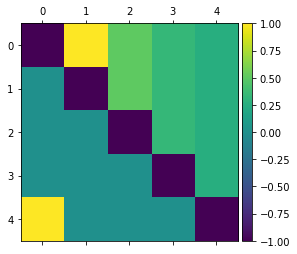

In [4]:
# test 1 : building a 'System' object

%matplotlib inline

syst = System()
print(syst.dim)
print(syst.state)
print(syst.J_0)
print(syst.noise)
print(syst.run)
syst.plotMatrix()

In [5]:
# test 1 : instanciation of class System

syst = System()
a = syst.noise_inpt
print(syst.noise_inpt)
mat = genNoise(dim=4, rule='nrm')
print(mat)

(1.0, 10.0)
[[ 7.90561422  0.          0.          0.        ]
 [ 0.         -4.33564478  0.          0.        ]
 [ 0.          0.          0.52592674  0.        ]
 [ 0.          0.          0.         25.16789265]]


state at t=0 :  [1. 0. 0. 0. 0.]
state at t=1 :  [0.9 0.  0.  0.  0.1]
state at t=2 :  [0.8125 0.0025 0.0025 0.0025 0.18  ]
state at t=3 :  [0.73620833 0.00695833 0.00683333 0.00675    0.24325   ]
state at t=4 :  [0.66993125 0.01291042 0.01245625 0.01215625 0.29254583]
.after reset :  [1. 0. 0. 0. 0.]
System.run() exit, runtime = 0.005 s
...after run :  [0.32432517 0.16216117 0.10810699 0.08107973 0.32432694]
state at t=4 :  [0.61257083 0.01996104 0.01892948 0.01825427 0.33028438]


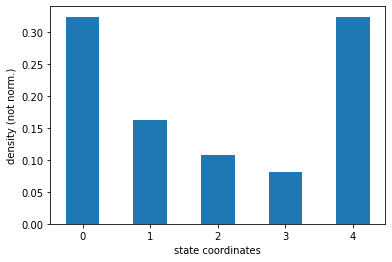

In [6]:
# test 2 : System.doStep(), System.reset(), System.run(), syst.plotState()

%matplotlib inline

syst = System()
for i in range(5) :
    print('state at t=%i : '%i, syst.state)
    syst.doStep()
syst.reset()
print('.after reset : ', syst.state)
syst.run()
print('...after run : ', syst.state)
print('state at t=4 : ', syst.states[:,4])
syst.plotState()

System.run() exit, runtime = 0.003 s


<IPython.core.display.Javascript object>


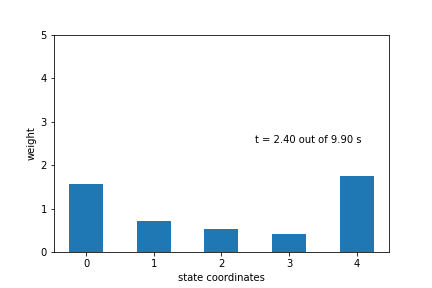

In [7]:
# test 3 : System.animateState()

%matplotlib notebook

syst = System()
syst.run()
syst.animateState()


 Object 'System' n°4604356944
-------------------------------------------------------------
 Simulation parameters
     samples      : 1000
     length       : 9 s
     timestep     : 0.010000 s
 System parameters
     dynamic type : ssr
     noise type   : no noise
 Current state
     current step : 0
     current time : 0 s
     state        : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
-------------------------------------------------------------



 Object 'System' n°4603765680
-------------------------------------------------------------
 Simulation parameters
     samples      : 401
     length       : 100 s
     timestep     : 0.250000 s
 System parameters
     dynamic type : ssr
     noise type   : no noise
 Current state
     current step : 0
     current time : 0 s
     state        : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
-------------------------------------------------------------




<IPython.core.display.Javascript object>


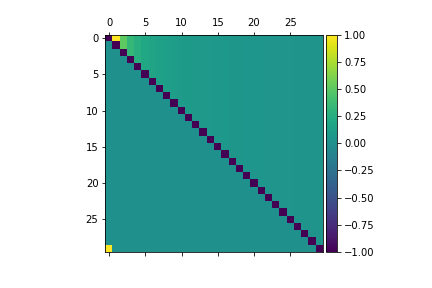

System.run() exit, runtime = 0.010 s


<IPython.core.display.Javascript object>


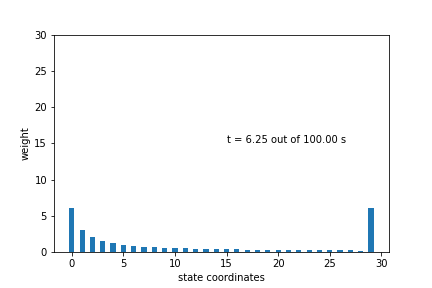

In [8]:
# test 4 : inputs

syst = System(dim=30, dt=0.01, n_step=1000)
syst.info()

syst = System(dim=30, dt=0.25, end_time=100)
syst.info()
syst.plotMatrix()
syst.run()
syst.animateState(log=False)

In [9]:
# test 5 : printing runtime (in System.run(), set 'delay' to 0.01)

syst = System(n_step=10000)
syst.run()

System.run() exit, runtime = 0.091 s


System.run() exit, runtime = 0.242 s


<IPython.core.display.Javascript object>


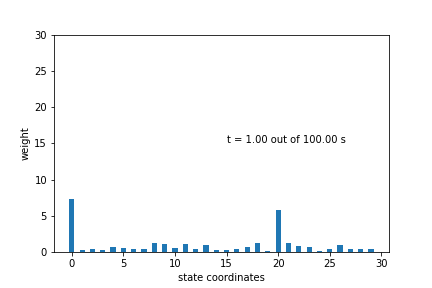

In [10]:
# test 6 : noise

syst = System(dim=30, dt=0.025, end_time=100, dyn='mfd', noise='nrm')
syst.run()
syst.animateState()

## Investigating the models

### Bouchaud-Mézard model

Lets build a class `BMtoolkit` to analyse the data generated by a simulation made by a `System` object.

To do :
- !! FIND GROWTH RATE !! `ndarray BMtoolkit.rescaling()` function to rescale the total wealth at all times (return a NEW `ndarray` and do not modify System.states),
- `ndarray BMtoolkit.approx()` that build a 2D-histogram of the transition rates for the macrostate (!! not the microstate !!),
- `System.export()` that can export data into a specified (or prompted) path,
- `BMtoolkit.import()` that import data from a specified (or prompted) path`
- a whole class `SimulationManager` that can conduct several simulations with several settings and save the results,
- curiosity : a function `BMtoolkit.coordHist()` that builds the histogram of single coordinate, and a function `BMtoolkit.plotHist()` that can display it,
- curiosity : a function `BMtoolkit.coordCovar()` that plots (the estimator of) the covariance matrix, and a function `BMtoolkit.plotCov()` that can plot it,
- change all 'density of state' to 'weight' in the notebook,
- consider changing from `totWeights` to `totW`,
- ...



In [38]:
class BMtoolkit:
    """all tool used to analyse a Bouchau-Mézard model
    Class variables :
        ...
    Input :
        ...
    BMtoolkit.data codenames :
        'av_w' : time sequence of all averaged weights (average wealth in Bouchaud-Mézard),
        'n_av_w' = the averaged weights, normalized by the (observed) exponential growth at each time-step,
        'max_w'  = the maximum weight,
        'min_w'  = the minimum,
        'rsc_states' = syst.states rescaled at each timestep by the average weight over agents (must be a stationnary process)
        ''       = ..."""

    def __init__(self) :
        self.syst = System()
        self.data = dict()
        return
    
    def load(self, syst) :
        """loads a 'System' object as the input source"""
        self.syst = syst
        return
    
    def maxW(self) :
        """calculates the max weight for each time t and store the resulting time-sequence in BMtoolkit.data['maw_W']"""
        self.data['max_W'] = np.amax(self.syst.states, axis=0)
        return
    
    def minW(self) :
        """calculates the min weight for each time t and store the resulting time-sequence in BMtoolkit.data['min_W']"""
        self.data['min_W'] = np.amin(self.syst.states, axis=0)
        return
    
    def ratio(self) :
        """calculates the ratio max/min for each timestep, stores data in BMtoolkit.data['ratio']"""
        self.data['ratio'] = np.amax(self.syst.states, axis=0)/np.amin(self.syst.states, axis=0)
        return
  
    def avW(self) :
        """will average the *weights* along all states for each time t and store the resulting time-sequence in BMtoolkit.data['av_w']"""
        self.data['av_w'] = np.average(self.syst.states, axis=0)
        return
    
    def normAvW(self) :
        """rescales the average-weight time sequence by deviding by its analytic expectancy exp((m+sim**2)t)
        stores the data in self.data['n_av_w']"""
        # getting input
        T = self.syst.T
        dt = self.syst.dt
        end_time = self.syst.end_time
        try:
            Ys = self.data['av_w']
        except:
            print("ERROR - BMtoolkit.normAvW() - BMtoolkit.data['av_w'] not assigned !\nEXECUTED BMtoolkit.avW()")
            self.avW()
            Ys = self.data['av_w']
        # naively claculating growth rate
        delta_t = (T-1)*dt
        growth = self.data['av_w'][-1]/self.data['av_w'][0]
        rate = np.log(growth)/delta_t
        A0 = self.data['av_w'][0]
        # normalizing
        Ts = np.linspace(0., end_time, T)
        Es = A0*np.exp(rate*Ts)
        self.data['n_av_w'] = Ys/Es
        # WRONG LINE !!! self.data['n_Av_W'] = self.data['n_Av_W']/np.average(self.data['n_Av_W'])
        return
    
    def rescale(self) :
        """rescales each agent's weight time sequence by deviding by its the average over agents
        stores the data in self.data['rsc_states']
        
        TO CLEAN"""
        # getting input
        try:
            avs = self.data['av_w']
        except:
            print("ERROR - BMtoolkit.rescale() - BMtoolkit.data['av_w'] not assigned !\nEXECUTED BMtoolkit.avW()")
            self.avW()
            avs = self.data['av_w']
        avs = 1/avs # taking the inverse
        self.data['rsc_states'] = np.multiply(self.syst.states, avs)
        return
    
    def plotData(self, key='', log=False, ylabel='') :
        """plots a given time sequence stored in BMtoolkit.data"""
        # getting input
        T = self.syst.T
        end_time = self.syst.end_time
        try:
            Ys = self.data[key]
        except:
            print("ERROR - BMtoolkit.plotData() - BMtoolkit.data['" + key + "'] not assigned !")
            return
        L = np.shape(Ys)[0]
        dt = self.syst.dt
        # plotting
        fig = plt.figure()
        Ts = np.linspace(0., (L-1)*dt, L)
        if log :
            plt.yscale('log')
        plt.plot(Ts, Ys)
        plt.xlabel('time (s)')
        plt.ylabel(ylabel)
        plt.show()
        return


 Object 'System' n°4811902880
-------------------------------------------------------------
 Simulation parameters
     samples      : 4000
     length       : 99 s
     timestep     : 0.025000 s
 System parameters
     dynamic type : mfd
     noise type   : BMs
 Current state
     current step : 0
     current time : 0 s
     state        : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....
-------------------------------------------------------------


System.run() exit, runtime = 0.184 s


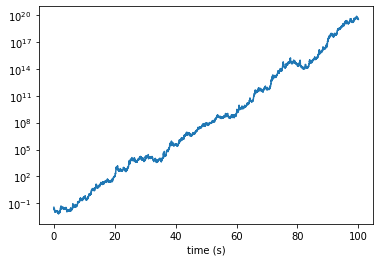

In [10]:
# test 7 : BMtoolkit class, summing weights and plotting

%matplotlib inline

syst = System(dim=30, dt=0.025, end_time=99.976, dyn='mfd', noise='BMs', noise_inpt=(0.3, 0.04))
syst.info()
syst.run()

tlk = BMtoolkit()
tlk.load(syst)
tlk.avW()
tlk.plotData(log=True, key='av_w')

We see that the average weight follows a non-stationnary dynamic (exponential).
We must than rescale it with its expectancy at each time (analytically calculated in [06]) :
$$\mathbb{E}_{t}\left(\bar{W}(t)\right) = \exp\left((m+\sigma^{2})t\right)$$
Thus we build the function `BMtoolkit.normAvW()` (see code above), which must be have access to the noise caracteristics in theory (fixed for the moment, see `genNoise()`).
In practice, the rate above is only true in the large $D \to \infty$ limit and does hold for smaller $D$. The effective rate is thus calculated.

We will keep : `mean = 0.3` and `sigm = 0.04`.

**Note : It is important to see that here averaging over agents $i$ is different than averaging over time $t$.**

System.run() exit, runtime = 0.046 s

 Object 'System' n°4805827104
-------------------------------------------------------------
 Simulation parameters
     samples      : 1001
     length       : 10 s
     timestep     : 0.010000 s
 System parameters
     dynamic type : mfd
     noise type   : BMs
 Current state
     current step : 1001
     current time : 10 s
     state        : [ 201.59390197  177.86023086  400.80...
-------------------------------------------------------------




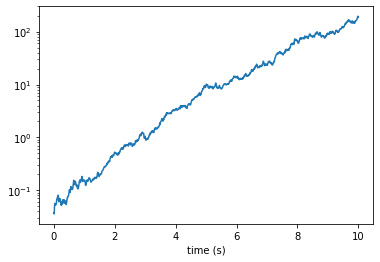

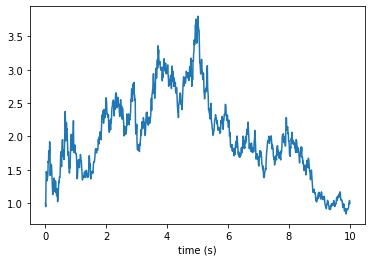

In [11]:
# test 8 : normalized average weight

syst = System(dim=30, dt=0.01, end_time=10, dyn='mfd', noise='BMs', noise_inpt=(0.3, 0.04))
syst.run()
syst.info()

tlk = BMtoolkit()
tlk.load(syst)
tlk.avW()
tlk.plotData(log=True, key='av_w')
tlk.normAvW()
tlk.plotData(log=False, key='n_av_w')

In [12]:
# test 9 : testing genNoise() parameters

syst = System(dim=5, dt=0.025, end_time=100, dyn='mfd', noise='abc', noise_inpt = (1,2,3))
for i in range(3) :
    mat = genNoise(dim=syst.dim, rule=syst.noise, inpt=syst.noise_inpt)
    print(mat)

ERROR - genNoise() - unknown noise rule, normal law used instead (mean=1., scale=10.)
Reminder :
    uni --> uniformly in [0, 1[
    bin --> binomial (1 sample)
    pow --> power-tail law (Pareto here)
    nrm --> normal law (scale=inpt[1]
    BMs --> normal law where scale=np.sqrt(2)*inpt[1]
[[ -3.79111172   0.           0.           0.           0.        ]
 [  0.          -0.08804996   0.           0.           0.        ]
 [  0.           0.          -5.67992664   0.           0.        ]
 [  0.           0.           0.          -5.01980441   0.        ]
 [  0.           0.           0.           0.         -13.57966643]]
ERROR - genNoise() - unknown noise rule, normal law used instead (mean=1., scale=10.)
Reminder :
    uni --> uniformly in [0, 1[
    bin --> binomial (1 sample)
    pow --> power-tail law (Pareto here)
    nrm --> normal law (scale=inpt[1]
    BMs --> normal law where scale=np.sqrt(2)*inpt[1]
[[ 5.26739894  0.          0.          0.          0.        ]
 [ 0.   

In [13]:
# test 10 : time indexation

syst = System(n_step=6, dt=0.3)
syst.run()

tf = syst.time
end_time = syst.end_time
T = syst.T
Ts = np.linspace(0., end_time, T)
syst.run()
tf = syst.time
print('Ts : ', Ts)
print('tf : ', tf)
print('end_time : ', end_time)
print('states[0](t) : ', syst.states[0,:])

System.run() exit, runtime = 0.002 s
System.run() exit, runtime = 0.001 s
Ts :  [0.  0.3 0.6 0.9 1.2 1.5]
tf :  1.8
end_time :  1.5
states[0](t) :  [0.7        0.5125     0.402625   0.34343125 0.3154     0.30519972]


Run in progess : 17.9 %
Run in progess : 39.9 %
Run in progess : 64.2 %
Run in progess : 88.4 %
System.run() exit, runtime = 4.508 s


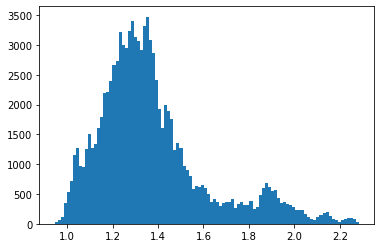

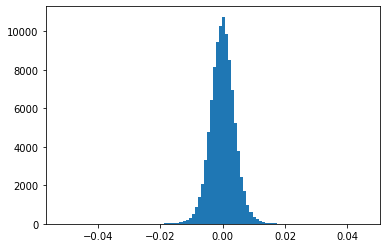

In [17]:
# draft for two deltaHist() and plotDeltaHist() functions

syst = System(dim=30, dt=0.001, end_time=100, dyn='mfd', noise='BMs', noise_inpt=(0.3, 0.04))
syst.run()

tlk = BMtoolkit()
tlk.load(syst)
tlk.avW()
tlk.normAvW()

T = syst.T
n_Av_W = tlk.data['n_av_w']
deltas = n_Av_W[1:]-n_Av_W[:T-1]

plt.figure()
hist1 = plt.hist(n_Av_W, bins=100)

plt.figure()
hist2 = plt.hist(deltas, bins=100)

In [18]:
# draft for a toDrivingMatrix() function

syst = System(dim=30, dt=0.001, end_time=10, dyn='mfd', noise='BMs', noise_inpt=(0.3, 0.04))
syst.run()

tlk = BMtoolkit()
tlk.load(syst)
tlk.avW()
tlk.normAvW()

T = syst.T
n_Av_W = tlk.data['n_av_w']
deltas = n_Av_W[1:]-n_Av_W[:T-1]



System.run() exit, runtime = 0.506 s


Run in progess : 25.4 %
Run in progess : 48.3 %
Run in progess : 74.4 %
Run in progess : 91.4 %
System.run() exit, runtime = 4.374 s
Run in progess : 27.2 %
Run in progess : 51.6 %
Run in progess : 72.0 %
Run in progess : 90.1 %
System.run() exit, runtime = 4.603 s
Run in progess : 24.1 %
Run in progess : 51.0 %
Run in progess : 78.1 %
System.run() exit, runtime = 3.825 s


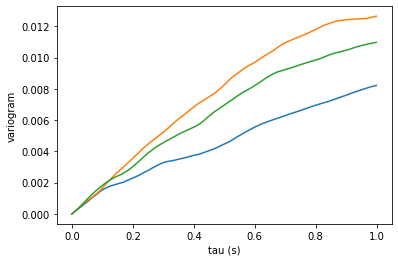

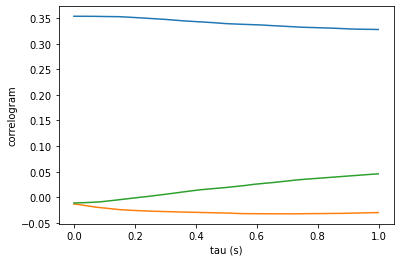

In [19]:
# calculating the variogram and autocorrelations of n_Av_W(t) (the two are equivalent)

def diff(tab, tau) :
    L = np.shape(tab)[0]
    deltas = np.zeros(L)
    if tau < L :
        deltas[:L-tau] = tab[tau:]-tab[:L-tau]
    else :
        print('ERROR - diff() - index out of range, return np.zeros(%d)'%(L))
    return deltas

def mult(tab, tau) :
    L = np.shape(tab)[0]
    prod = np.zeros(L)
    if tau < L :
        prod[:L-tau] = tab[tau:]*tab[:L-tau]
    else :
        print('ERROR - mult() - index out of range, return np.zeros(%d)'%(L))
    return prod



syst = System(dim=30, dt=0.001, n_step=100000, dyn='mfd', noise='BMs', noise_inpt=(0.3, 0.04))

for i in range(3) :
    syst.reset()
    syst.run()
    tlk = BMtoolkit()
    tlk.load(syst)
    tlk.avW()
    tlk.normAvW()
    #tlk.plotNAvW()
    n_Av_W = tlk.data['n_av_w']
    # variogram
    avs = []
    trange = int(T/10)
    norm = np.average(n_Av_W[:T-trange]**2)
    for tau in range(trange) :
        deltas = diff(n_Av_W, tau)
        av = np.average(deltas[:T-trange]**2)/norm
        avs.append(av)
    taus = np.arange(trange)*syst.dt
    plt.figure('v')
    plt.plot(taus, avs)
    plt.xlabel('tau (s)')
    plt.ylabel('variogram')
    # correlogram
    avs = []
    norm = np.average(n_Av_W[:T-trange]**2)
    for tau in range(trange) :
        prod = mult(n_Av_W, tau)
        av = (np.average(prod[:T-trange]**2)-norm)/norm
        avs.append(av)
    plt.figure('c')
    plt.plot(taus, avs)
    plt.xlabel('tau (s)')
    plt.ylabel('correlogram')



 

Run in progess : 22.6 %
Run in progess : 39.3 %
Run in progess : 62.6 %
Run in progess : 86.9 %
System.run() exit, runtime = 4.569 s
Run in progess : 27.0 %
Run in progess : 53.4 %
Run in progess : 79.8 %
System.run() exit, runtime = 3.792 s
Run in progess : 26.8 %
Run in progess : 53.2 %
Run in progess : 79.6 %
System.run() exit, runtime = 3.804 s


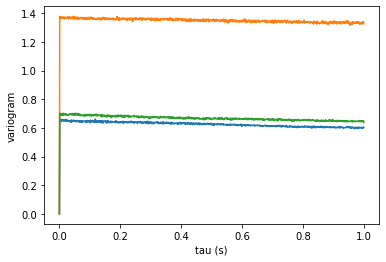

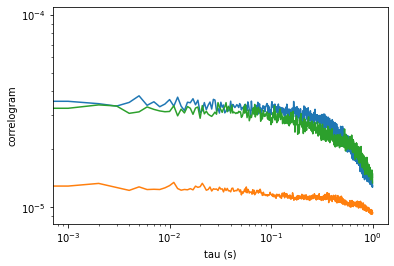

In [19]:
# investigating the increments

syst = System(dim=30, dt=0.001, n_step=100000, dyn='mfd', noise='BMs', noise_inpt=(0.3, 0.04))

for i in range(3) :
    syst.reset()
    syst.run()
    tlk = BMtoolkit()
    tlk.load(syst)
    tlk.avW()
    tlk.normAvW()
    #tlk.plotNAvW()
    n_Av_W = tlk.data['n_av_w']
    increments = n_Av_W[1:]-n_Av_W[:syst.T-1] # weird
    # variogram
    avs = []
    trange = int(T/10)
    norm = np.average(increments[:T-trange]**2)
    for tau in range(trange) :
        deltas = diff(increments, tau)
        av = np.average(deltas[:syst.T-trange]**2)/norm
        avs.append(av)
    taus = np.arange(trange)*syst.dt
    plt.figure('v')
    plt.plot(taus, avs)
    plt.xlabel('tau (s)')
    plt.ylabel('variogram')
    # correlogram
    avs = []
    norm = np.average(increments[:syst.T-1-trange]**2)
    for tau in range(trange) :
        prod = mult(increments, tau)
        av = np.average(prod[:syst.T-1-trange]**2)/norm
        avs.append(av)
    plt.figure('c')
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(taus, avs)
    plt.xlabel('tau (s)')
    plt.ylabel('correlogram')

Run in progess : 39.4 %
Run in progess : 98.4 %
System.run() exit, runtime = 2.035 s


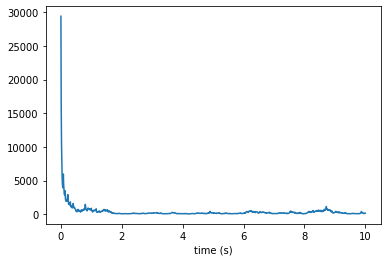

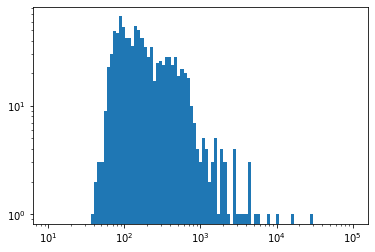

In [20]:
# draft for studying max/min

syst = System(dim=300, dt=0.01, end_time=10, dyn='mfd', noise='BMs', noise_inpt=(0.3, 0.04))
syst.run()

tlk = BMtoolkit()
tlk.load(syst)
tlk.ratio()
tlk.plotData(log=False, key='ratio')

ratios = tlk.data['ratio']

plt.figure()
plt.xscale('log')
plt.yscale('log')
l_bins = np.logspace(1,5,100)
hist1 = plt.hist(ratios, bins=l_bins)

## Is Bouchaud-Mézard ergodic ?

The goal here is to establish for which set of parameters our model can be considered in a steady state. The underlying question is : *for which time-scales is can it be consider ergodic ?* (all states have been reached)

The parameters that must have an influence are :
- the timestep $dt$,
- the timeframe we are considering $T$,
- the number of agents $D$,
- the intensity of noise ($m$) and field $\Vert J_0 \Vert$, both homogenous to $t^{-1}$,
- ...

### Experiment 1 : From when do we have a stable histogram for an agent ?

Exp : plot the timely histogram of a single agent's weight, for a single experiment.
See at what time it begins to stabilize and to smoothen.

Parameters :
- `dim=30`,
- `dt=0.0001`,
- `end_time=20`,
- `dyn='mfd'`,
- `noise='BMs'`,
- `noise_inpt=(0.3, 0.04)`.

In [25]:
syst = System(dim=30, dt=0.0001, end_time=20, dyn='mfd', noise='BMs', noise_inpt=(0.3, 0.04))
syst.run()

Run in progess : 10.5 %
Run in progess : 21.1 %
Run in progess : 31.3 %
Run in progess : 41.3 %
Run in progess : 52.7 %
Run in progess : 64.0 %
Run in progess : 74.5 %
Run in progess : 84.0 %
Run in progess : 95.1 %
System.run() exit, runtime = 9.484 s


<IPython.core.display.Javascript object>


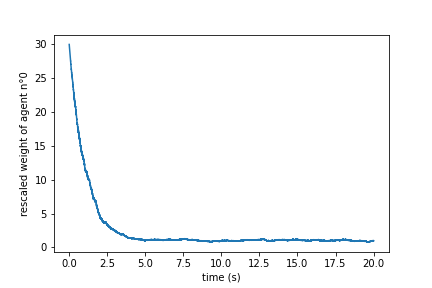

<IPython.core.display.Javascript object>


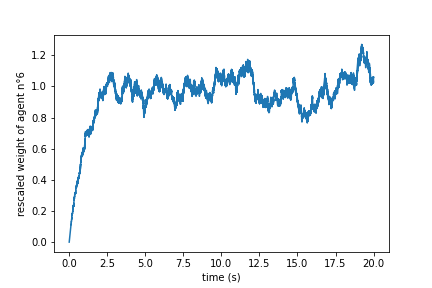

In [35]:
# needs to run the cell just above !

%matplotlib notebook

tlk = BMtoolkit()
tlk.load(syst)
tlk.avW()
tlk.rescale()
tlk.data['ag_0'] = tlk.data['rsc_states'][0,:]
tlk.plotData(key='ag_0', ylabel='rescaled weight of agent n°0')
tlk.data['ag_6'] = tlk.data['rsc_states'][6,:]
tlk.plotData(key='ag_6', ylabel='rescaled weight of agent n°6')

Up : agent n°0
Bottom : agent n°6

For this experiement, we see that the system takes 5 seconds to damp the start state ([1., 0., ..., 0.]).
This gives an idea of the speed of the dynamic for this given set of parameters.

Run in progess : 11.1 %
Run in progess : 22.1 %
Run in progess : 34.0 %
Run in progess : 45.5 %
Run in progess : 57.2 %
Run in progess : 68.4 %
Run in progess : 79.6 %
Run in progess : 90.7 %
System.run() exit, runtime = 8.906 s


<IPython.core.display.Javascript object>


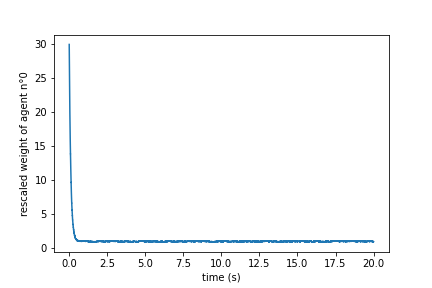

<IPython.core.display.Javascript object>


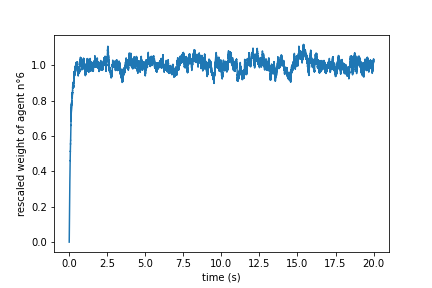

In [36]:
syst = System(dim=30, dt=0.0001, end_time=20, dyn='mfd', noise='BMs', noise_inpt=(0.3, 0.04))
syst.rebuildMatrix(p=10)
syst.run()

tlk = BMtoolkit()
tlk.load(syst)
tlk.avW()
tlk.rescale()
tlk.data['ag_0'] = tlk.data['rsc_states'][0,:]
tlk.plotData(key='ag_0', ylabel='rescaled weight of agent n°0')
tlk.data['ag_6'] = tlk.data['rsc_states'][6,:]
tlk.plotData(key='ag_6', ylabel='rescaled weight of agent n°6')

For this set of parameter (same but with $\Vert J_0 \Vert$ 10 times higher (= higher transition rates), the dynamics seems to be proportionnaly faster. This is expected.
However, changeing the magnitude of noise or its variance does not change much of the speed of the system.

We will now plot the histogram for an agent's weight

In [40]:
syst = System(dim=30, dt=0.0001, end_time=20, dyn='mfd', noise='BMs', noise_inpt=(0.3, 0.04))
syst.run()

Run in progess : 11.0 %
Run in progess : 22.0 %
Run in progess : 33.1 %
Run in progess : 42.9 %
Run in progess : 54.5 %
Run in progess : 64.9 %
Run in progess : 76.2 %
Run in progess : 87.3 %
Run in progess : 98.3 %
System.run() exit, runtime = 9.177 s


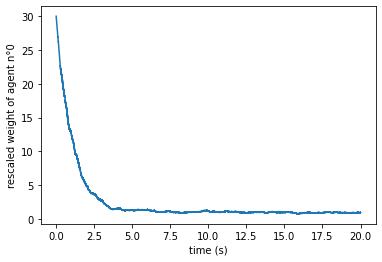

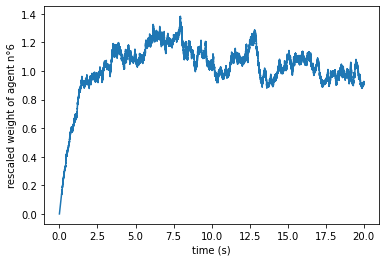

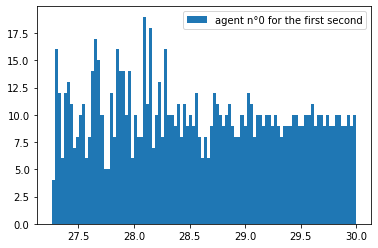

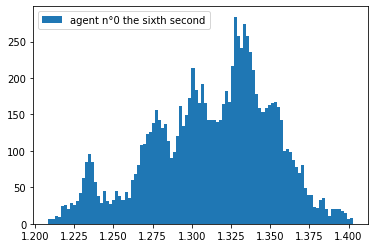

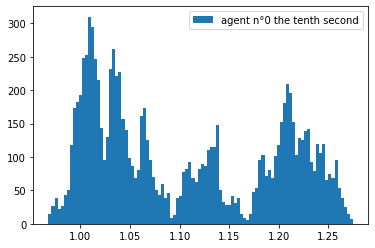

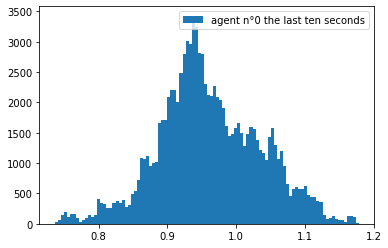

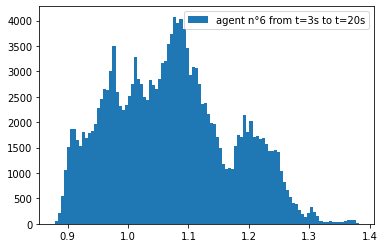

In [57]:
# plotting a histogram

%matplotlib inline

tlk = BMtoolkit()
tlk.load(syst)
tlk.avW()
tlk.rescale()
# reference curves
tlk.data['ag_0'] = tlk.data['rsc_states'][0,:]
tlk.plotData(key='ag_0', ylabel='rescaled weight of agent n°0')
tlk.data['ag_6'] = tlk.data['rsc_states'][6,:]
tlk.plotData(key='ag_6', ylabel='rescaled weight of agent n°6')
# histogram for agent n°0 for the first second
plt.figure()
plt.hist(tlk.data['rsc_states'][0,:1000], bins=100, label='agent n°0 for the first second')
plt.legend()
plt.show()
# histogram for agent n°0 the sixth second
plt.figure()
plt.hist(tlk.data['rsc_states'][0,50000:60000], bins=100, label='agent n°0 the sixth second')
plt.legend()
plt.show()
# histogram for agent n°0 the tenth second
plt.figure()
plt.hist(tlk.data['rsc_states'][0,90000:100000], bins=100, label='agent n°0 the tenth second')
plt.legend()
plt.show()
# histogram for agent n°0 the last ten seconds
plt.figure()
plt.hist(tlk.data['rsc_states'][0,100000:200000], bins=100, label='agent n°0 the last ten seconds')
plt.legend()
plt.show()
# histogram for agent n°6 from t=3s to t=20s
plt.figure()
plt.hist(tlk.data['rsc_states'][6,30000:200000], bins=100, label='agent n°6 from t=3s to t=20s')
plt.legend()
plt.show()

Conclusion :
- the relaxation time must be taken into account and assessed to plot meaning full histogram,
- for out input, it seems that the time-frame of 10s (when relax. time is 5s) is not enough,
- ...

### Experiment n°2 : ???

verbatim lorem ipsus dolor

In [57]:
# experiment 1 : plotting histograms



## To do :
- add the physical dimensions everyhere (top to bottom),
- sort-out the confusion between dimension/state/macrostate/microstate, as well as the confusion between particle/system/etc. In Boltzmann-Gibbs each dimension $i$ is a microstate for each particle, and a state $\mathbf{X}$ is a macrostate of the whole system. In SSR (or description in *General description*) a dimension $i$ is a macrostate and a state $\mathbf{X}$ is (yet) the probability distribution of the macrostates for a single particle (change SSR to many particles ??),
- double-check variables and axis names, so it has the right physical meaning (!! microstate != macrostate),
- re-organize the notebook's structure (check for repetitions and omissions),
- ...

In [32]:
Ts = np.arange(0, 5)
print(Ts)

[0 1 2 3 4]


In [23]:
st = np.array([[1,2,3],[.1,.2,.3]])
re = np.array([2,4,8])
a = np.multiply(st,re)
print(a)

[[ 2.   8.  24. ]
 [ 0.2  0.8  2.4]]
